# 집값 예측 경진대회

## 패키지 import 및 데이터 전처리

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [196]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/test.csv')

In [197]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


`-` id는 필요없으니 제거

In [198]:
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 결측치는 없다

`-` 분석의 편의를 위해 컬럼명을 바꾸겠다

In [199]:
## 공백과 슬래쉬를 _로 대체 1을 숫자가 아닌 다른 문자로 바꿈 
df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in test.columns])), inplace = True) 

`-` 범주형 변수는 Exter Qual(외관 재료 품질;4개), Kitchen Qual(부엌 품질; 4개), Bsmt Qual(지하실 높이;5개)이다

`-` 총 5개의 등급이 존재하는데 Poor 등급은 Bsmt Qual에 1개 존재한다(나머지는 0개)

`-` 아예 poor등급이 존재하지 않는걸 수 도 있고 poor등급이 존재하는데 poor등급에 해당하는 건물이 존재하지 않는걸 수 도 있다

`-` 편의상 후자라고 생각하자(사실 후자가 맞다; 아님말고)

`-` 이들은 순서형 변수이므로 라벨 인코딩을 해주자

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의해주자

In [200]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 0~4점
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [201]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))

In [202]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [203]:
df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
1,7,1352,3,2,466,3,1352,1352,4,2,2006,2007,2006,194000
2,5,900,2,1,288,2,864,900,2,1,1967,1967,1967,123000
3,5,1174,2,2,576,3,680,680,2,1,1900,2006,2000,135000
4,7,1958,3,3,936,3,1026,1026,3,2,2005,2005,2005,250000


`-` 라벨 인코딩이 잘 되었다

In [204]:
df[df.Garage_Yr_Blt == max(df.Garage_Yr_Blt)]

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
254,8,1564,3,2,502,4,1546,1564,3,2,2006,2007,2207,267300


`-` Garage_Yr_Blt가 2207년으로 되어있다

`-` 이를 2007년으로 바꿔주자

In [205]:
df.loc[254, 'Garage_Yr_Blt'] = 2007

### 로그 변환 및 이상점 제거

`-` 앞서 EDA에서 집값(target)이 오른쪽으로 꼬리가 긴 분포임을 확인했다

`-` 정규분포로 맞춰주기 위해 로그변환을 하자

In [114]:
import scipy.stats as stats

<AxesSubplot:>

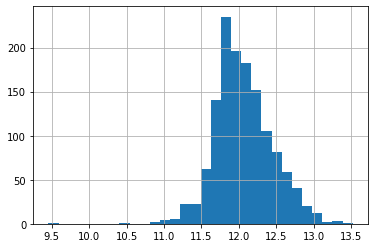

In [10]:
np.log(df['target']).hist(bins = 30)

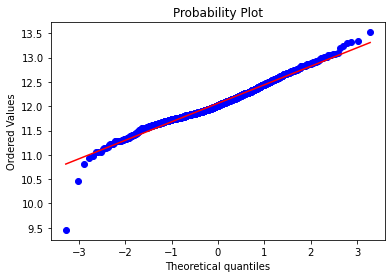

In [11]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 로그 변환을 했지만 정규분포를 따르지 않는것처럼 보인다

`-` 샤피로-윌크 검정을 통해 정확히 확인하자

In [12]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [13]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(4.748497602069524e-13, 0.08070163740417918)

`-` 안타깝게도 정규분포를 따르지 않는다

`-` 왜도는 $0.08$로 거의 $0$

`-` 그런데 Q-Q플랏을 보면 심각한 이상치가 보인다(-3부근에 2개)

`-` 저런 이상치를 예측하는 것은 불가능해보이니 제거하자

`-` 값이 큰쪽으로도 이상점이 있는데 제거할지 말지 고민중이다

`-` 가장 비싼 집이 745000 달러인데 Gr_Liv_Area(지상층 생활 면적)이 4476으로 매우 넓다!

`-` 근데 생각해보니 제거하는 것이 맞는 것 같다(심각한 이상치로 인해 큰 영향을 끼칠 수 있음)

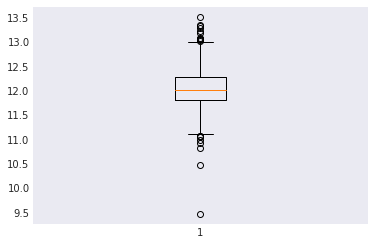

In [11]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df['target']))
plt.show()

`-` 로그 변환을 해서 나온 이상치들을 제거하자

In [10]:
def remove_outlier(df):
    Q1 = np.log(df).quantile(0.25)
    Q3 = np.log(df).quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = (np.log(df) >= Q1 - 1.5*IQR) & (np.log(df) <= Q3 + 1.5*IQR)
    return filter_

`-` df의 이상점을 제거한 df2를 만듦

In [47]:
df2 = df.copy()

In [44]:
df2['Overall_Qual'].unique()

array([10,  7,  5,  8,  6,  3,  4,  9,  2], dtype=int64)

`-` 위에서 제거한 이상점은 target의 이상점이다

`-` 그런데 위와 같이 이상점을 제거하면 target 전체를 기준으로 매우 큰 값 또는 작은 값만 제거된다

`-` 하지만 Overall Qual과 같은 변수로 target을 나눠서 보면 target 전체로 봤을 때의 이상점과 다르다

`-` 그렇기에 Overall Qual에 따른 target의 이상점을 제거하겠다

`-` 예컨대 Overall Qual이 3일 때 이상점으로 30만 달러의 집이 있다고 해도

`-` target 전체로 봤을 땐 이상점이 아니다

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거하자

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거할려고 했는데

`-` Overlall_Qual에 따라 모델을 만들것이 아니라서 전체 target의 이상점만 제거하기로 했다

In [30]:
# l = []
# for i in df2['Overall_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Overall_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가
             
# l = list(set(l))

In [19]:
# l = []
# for i in df2['Kitchen_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Kitchen_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가

# l = list(set(l))
# l = list(set(l) & set(remove_outlier(df2[['target']]).query('target == True').index.tolist()))

In [32]:
# df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

In [49]:
df2 = df2[remove_outlier(df2['target'])]

<AxesSubplot:>

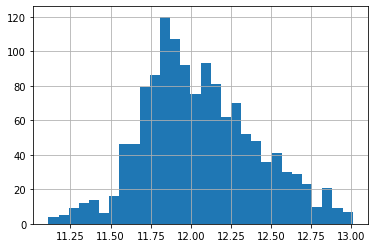

In [50]:
np.log(df2['target']).hist(bins = 30)

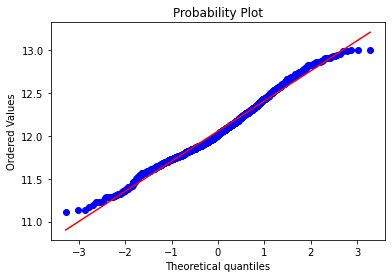

In [51]:
_ = stats.probplot(np.log(df2['target']), plot = plt)

In [52]:
test_stat, p_val = stats.shapiro(np.log(df2['target']))

In [53]:
p_val, np.log(df2['target']).skew() ## p값과 왜도

(2.6139335140840103e-09, 0.30128743590449364)

`-` 이상으로 이상점 제거를 끝냈다

In [73]:
dt = df2.copy()

In [74]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [75]:
dt['gap_year_now_bulit'] = 2022 - dt['Year_Built']

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

In [76]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그렇기에 원핫인코딩을 하고 둘을 곱한 파생 변수를 만들고 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 일단은 하지 말자

`-` 지상층 생활 면적과 1층 면적과 지하실 면적을 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [77]:
dt['Gr_Liv_Area'] = np.log(dt['Gr_Liv_Area'])
dt['Garage_Area'] = np.log(dt['Garage_Area'])
dt['First_Flr_SF'] = np.log(dt['First_Flr_SF'])
dt['Total_Bsmt_SF'] = np.log(dt['Total_Bsmt_SF'])

In [79]:
dt.head() ## 로그 변환이 잘 되었다

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,10,7.779885,4,3,6.875232,4,7.779885,7.779885,4,2,19
1,7,7.209340,3,2,6.144186,3,7.209340,7.209340,4,2,16
2,5,6.802395,2,1,5.662960,2,6.761573,6.802395,2,1,55
3,5,7.068172,2,2,6.356108,3,6.522093,6.522093,2,1,122
4,7,7.579679,3,3,6.841615,3,6.933423,6.933423,3,2,17


## 모델링(부스팅)

`-` 여러가지 부스팅 모델을 사용해보자

### 스케일링

`-` z-점수 스케일링이나 로버스트 스케일링이나 비슷하다

`-` 계수를 통해 Overall_Qual과 Gr_Liv_Area이 매우 중요하며 그 다음은 Bsmt_Qual이다

`-` Kitchen_Qual과 Total_Bsmt_SF이 그 다음이며 나머지는 비슷하다

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
## z-score 스케일러 생성
standard_scaler = StandardScaler()

## 스케일링
dt_scaled = standard_scaler.fit_transform(dt)
dt_scaled_df = pd.DataFrame(data = dt_scaled, columns = dt.columns)

In [82]:
dt_scaled_df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.955073,1.679132,2.822267,1.762432,1.909881,2.232825,2.375787,2.479985,2.041109,0.815269,-1.030914
1,0.626179,-0.197651,1.037875,0.213310,0.005244,0.693704,0.801414,0.644440,2.041109,0.815269,-1.134062
2,-0.926417,-1.536280,-0.746518,-1.335811,-1.248520,-0.845416,-0.434164,-0.664775,-0.875701,-1.021159,0.206866
3,-0.926417,-0.662018,-0.746518,0.213310,0.557376,0.693704,-1.094989,-1.566557,-0.875701,-1.021159,2.510511
4,0.626179,1.020562,1.037875,1.762432,1.822298,0.693704,0.040043,-0.243234,0.582704,0.815269,-1.099679


`-` 또한 Qual 관련 변수로 Overall Qual만 사용해봤는데 성능이 더 안좋게 나왔다(선형 회귀)

`-` 그래서 Qual 관련 변수를 추가했다

`-` 또한 현재 연도에서 완공 연도의 차이를 파생변수로 만들어 추가했다

`-` 사실 연도 변수는 포함시킬지 말지 고민했다

`-` 최근 연도일수록 집값이 평균적으로 높을텐데

`-` 이는 연도때문이라기 보다는 다른 변수에 의한 것이라 생각했기 때문이다

`-` 예컨대 과거에는 기술 등의 문제로 더 좋은 건물을 짓지 못했지만 최근에는 가능해진 상황

`-` 하지만 train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 포함하고 모델링 해보기로 했다

### 교차 검증

In [40]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

In [84]:
x_train, x_valid, y_train, y_valid = train_test_split(dt_scaled_df, target, shuffle = True, test_size = 0.2, random_state = 22)

In [85]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [37]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [38]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) ## 로그 변환을 위한 손실 함수

In [41]:
score = make_scorer(my_custom_loss_func, greater_is_better = False) ## 작을수록 좋다 

In [149]:
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3)
cb = CatBoostRegressor(random_state = 222, learning_rate = 0.03, n_estimators = 500, depth = 3, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 3, learning_rate = 0.03) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 500, max_depth = 3, learning_rate = 0.03)

In [131]:
for model in [gb, cb, xgb, lgb]:
    scores = cross_validate(model, x_train, log_y_train, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', -scores['test_score'])
    print('평균 교차 검증 NMAE: ', np.mean(-scores['test_score']))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.09825523 0.11957861 0.09228815 0.1009453  0.08686296 0.08607822
 0.09723404 0.08882254 0.09167116 0.07969104]
평균 교차 검증 NMAE:  0.09414272571258657
valid에 대한 검증 NMAE:  0.09327363829345853
---------------------------------------------
교차 검증별 NMAE:  [0.09168768 0.11198073 0.09045588 0.10705738 0.08097689 0.07740045
 0.10341037 0.0884669  0.0949103  0.07875323]
평균 교차 검증 NMAE:  0.09250998090891124
valid에 대한 검증 NMAE:  0.09537103423527143
---------------------------------------------
교차 검증별 NMAE:  [0.09469139 0.11876199 0.09434135 0.1018124  0.08281141 0.08264961
 0.09394308 0.09010295 0.09143423 0.08040145]
평균 교차 검증 NMAE:  0.09309498670321215
valid에 대한 검증 NMAE:  0.09646062690079403
---------------------------------------------
교차 검증별 NMAE:  [0.09354834 0.11601373 0.08962922 0.0981409  0.08753513 0.08450661
 0.09786521 0.08918322 0.09336603 0.07587111]
평균 교차 검증 NMAE:  0.09256595140948579
valid에 대한 검증 NMAE:  0.0951102884570039


`-` Adaboost를 제외하면 성능이 괜찮다

### 앙상블

`-` 위에서 만든 모델을 섞어 test 데이터를 예측하자

In [138]:
test['gap_year_now_bulit'] = 2022 - test['Year_Built']

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

In [139]:
test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그렇기에 원핫인코딩을 하고 둘을 곱한 파생 변수를 만들고 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 일단은 하지 말자(하지 말고 그냥 드랍하자)

`-` 지상층 생활 면적과 1층 면적과 지하실 면적과 연도를 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [140]:
test['Gr_Liv_Area'] = np.log(test['Gr_Liv_Area'])
test['Garage_Area'] = np.log(test['Garage_Area'])
test['First_Flr_SF'] = np.log(test['First_Flr_SF'])
test['Total_Bsmt_SF'] = np.log(test['Total_Bsmt_SF'])

In [141]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [142]:
test_scaled = standard_scaler.transform(test)
test_scaled_df = pd.DataFrame(data = test_scaled, columns = test.columns)

In [144]:
test_scaled_df.head() ## 로그 변환이 잘 되었다

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.178775,0.743798,1.037875,0.213310,1.072783,2.232825,1.591165,1.565202,2.041109,0.815269,-1.168445
1,-0.150119,-0.930456,-0.746518,-1.335811,-1.723533,-0.845416,0.186688,-0.072262,-0.875701,-1.021159,0.860138
2,-0.150119,0.300372,1.037875,0.213310,-0.144332,0.693704,-0.802633,-1.170850,0.582704,0.815269,-0.927765
3,-0.150119,1.748530,1.037875,1.762432,1.224174,0.693704,0.374006,0.146130,0.582704,0.815269,-1.065296
4,-0.926417,-1.060687,-0.746518,0.213310,1.012715,-0.845416,0.077441,-0.199632,-0.875701,-1.021159,0.172483


In [145]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True)

In [148]:
log_target = np.log(target)

`-` cat 부스트

In [151]:
cb_valid = []
cb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    cb = CatBoostRegressor(random_state = 222, learning_rate = 0.03, n_estimators = 500, depth = 3, loss_function = 'MAE', verbose = 0)
    cb.fit(x_train, y_train)
    y_predict = np.exp(cb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(cb.predict(test_scaled_df)) ## test셋 예측

    cb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 그래디언트 부스트

In [152]:
gb_valid = []
gb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    gb = GradientBoostingRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3) 
    gb.fit(x_train, y_train)
    y_predict = np.exp(gb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(gb.predict(test_scaled_df)) ## test셋 예측

    gb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    gb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` xgb

In [153]:
xgb_valid = []
xgb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    xgb = XGBRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3) 
    xgb.fit(x_train, y_train)
    y_predict = np.exp(xgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(xgb.predict(test_scaled_df)) ## test셋 예측

    xgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    xgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` lgbm

In [154]:
lgb_valid = []
lgb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    lgb = LGBMRegressor(random_state = 22, n_estimators = 700, max_depth = 3, learning_rate = 0.03)
    lgb.fit(x_train, y_train)
    y_predict = np.exp(lgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(lgb.predict(test_scaled_df)) ## test셋 예측

    lgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    lgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 4개의 모형을 앙상블하자

In [271]:
pred = (rf_predict + gb_predict + xgb_predict + lgb_predict) * 0.25 ## 예전 방식
# pred = (gb_predict + xgb_predict + lgb_predict) / 3 ---> 이게 점수 더 잘나옴(랜덤 포레스트가 별로인 듯)
# 점수는 0.10217이다

In [166]:
pred = (cb_predict + gb_predict + xgb_predict + lgb_predict) / 4

In [159]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [167]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,338903.325696
1,2,132275.668027
2,3,175242.763379
3,4,246726.603024
4,5,134197.295835


In [165]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission9.csv', index = False)

## 이상점 제거 X

`-` 이상점을 제거하지 않아봄(트리 기반 모델은 이상점에 덜 민감함)

`-` 또한 표본이 그리 많지 않기에 이상점을 제거하지 않는것이 나을 수 있다(데이터는 소중)

In [134]:
dt = df.copy()

`-` 차고 완공 연도 피쳐는 드랍(의미 없어 보인다)

In [135]:
dt.drop('Garage_Yr_Blt', axis = 1, inplace = True)
#test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

In [136]:
target = dt['target']  ## target
dt.drop('target', axis = 1, inplace = True)   ## target 제외한 데이터프레임

### 파생변수 생성

`-` 일단은 스케일링 하지 않음

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

In [137]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, shuffle = True, test_size = 0.2, random_state = 22)

In [138]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [61]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [62]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) ## 로그 변환을 위한 손실 함수

In [63]:
score = make_scorer(my_custom_loss_func, greater_is_better = False) ## 작을수록 좋다 

In [30]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')

In [139]:
log_target = np.log(target)

In [140]:
scores = cross_validate(rf, dt, log_target, scoring = score, cv = 10)
rf.fit(x_train, log_y_train)
print('-----------------랜덤포레스트---------------------')
print('교차 검증별 NMAE: ', abs(scores['test_score']))
print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

-----------------랜덤포레스트---------------------
교차 검증별 NMAE:  [0.0951445  0.09767047 0.10612592 0.09043182 0.0955651  0.08948114
 0.10456766 0.10078583 0.10263118 0.09592502]
평균 교차 검증 NMAE:  0.09783286296007823
valid에 대한 검증 NMAE:  0.1007880289159616


In [32]:
scores = cross_validate(rf, dt, log_target, scoring = score, cv = 10)
rf.fit(x_train, log_y_train)
print('-----------------랜덤포레스트---------------------')
print('교차 검증별 NMAE: ', abs(scores['test_score']))
print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

-----------------랜덤포레스트---------------------
교차 검증별 NMAE:  [0.09518406 0.09781884 0.10490807 0.09290233 0.09542523 0.08894368
 0.10595646 0.10108673 0.10330389 0.0964076 ]
평균 교차 검증 NMAE:  0.09819368951488101
valid에 대한 검증 NMAE:  0.10126586786131081


In [33]:
rf.fit(dt, target)

RandomForestRegressor(criterion='mae', random_state=22)

In [142]:
dict(zip(rf.feature_names_in_, rf.feature_importances_)) ## 연도 피쳐 포함

{'Overall_Qual': 0.3378385327427716,
 'Gr_Liv_Area': 0.1468019580807601,
 'Exter_Qual': 0.011952640943769247,
 'Garage_Cars': 0.010421908555938442,
 'Garage_Area': 0.12440988468275409,
 'Kitchen_Qual': 0.011950246437489973,
 'Total_Bsmt_SF': 0.07641459733627338,
 'First_Flr_SF': 0.09086582072221813,
 'Bsmt_Qual': 0.018361467288149972,
 'Full_Bath': 0.058033644454802774,
 'Year_Built': 0.06463448204518264,
 'Year_Remod_Add': 0.04831481670988958}

`-` 쓸모없는 변수 : Exter_Qual, Garage_Cars, Kitchen_Qual, Bsmt_Qual, Garage_Yr_Blt

In [262]:
dict(zip(rf.feature_names_in_, rf.feature_importances_))

{'Overall_Qual': 0.37293462948796124,
 'Gr_Liv_Area': 0.16089608391551238,
 'Garage_Cars': 0.014278231901710847,
 'Garage_Area': 0.12494360623796022,
 'Total_Bsmt_SF': 0.10065061657514864,
 'First_Flr_SF': 0.0935867623506591,
 'Full_Bath': 0.06402602105445104,
 'ord_Exter_Qual': 0.012468516017666686,
 'ord_Kitchen_Qual': 0.019439162543942744,
 'ord_Bsmt_Qual': 0.036776369914987075}

In [284]:
_ = pd.DataFrame(dict(zip(rf.feature_names_in_, rf.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

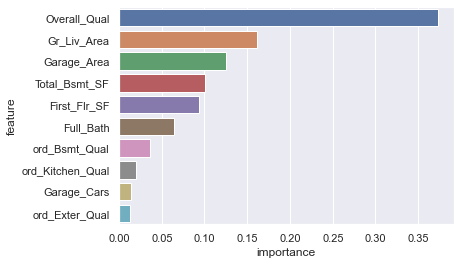

In [285]:
sns.barplot(y = 'feature', x = 'importance', data = _)

`-` 이상점 제거 안하고 딱히 전처리 안했을 때 랜덤포레스트의 성능과 피쳐의 중요도는 위와 같다

`-` 위를 기반으로 파생변수를 생성하자

<AxesSubplot:xlabel='Garage_Area', ylabel='Count'>

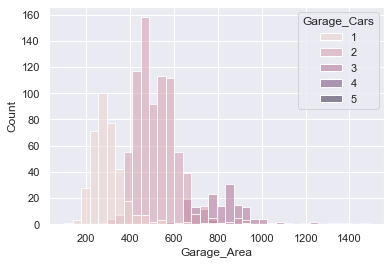

In [292]:
sns.histplot(data = dt, x = 'Garage_Area', hue= 'Garage_Cars')

`-` 차고의 면적과 차고에 들어가는 차량의 개수는 강한 상관관계를 보인다

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그래서 차고에 들어가는 차량의 개수가 1인지 2인지 3인지를 구분하려고 한다

`-` 원핫인코딩을 하고 차고 면적을 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 위와 같이 하니 별로 성능이 좋지 않았다

In [293]:
sum(dt['Garage_Cars'] >= 4) ## 차고에 들어가는 차량 개수가 4,5인 경우는 12개 뿐이다

12

`-` 지상층(Ground Living Area)는 땅 위에 있는 전체 면적을 이야기하는데 차고와 지하실을 제외하고 계산한다

`-` 따라서 `Gr Liv Area - 1st Flr SF > 0` 일 경우에 2층이 있는 것이므로 2층 면적 피처와 2층의 존재 여부를 새로운 피처로 생성하자

`-` 2층을 넘어서 3층까지 있을 수 있는데 일단은 그냥 2층으로 판단하자

`-` 또한 지상층 면적과 차고 면적, 지하실 면적을 더해 전체 집의 면적 피쳐를 만들자

`-` 그 밖에 다양한 파생변수를 만들자

<AxesSubplot:xlabel='First_Flr_SF', ylabel='Gr_Liv_Area'>

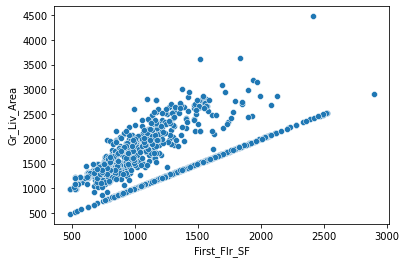

In [36]:
sns.scatterplot(data = dt, x = 'First_Flr_SF', y ='Gr_Liv_Area')

`-` 참고 : https://dacon.io/competitions/official/235869/codeshare/4304?page=1&dtype=recent

In [47]:
def feature_eng(data_):
    data = data_.copy()
    data['Year_Gap_Remod'] = data['Year_Remod_Add'] - data['Year_Built'] ## 리모델링 연도와 완공 연도의 차이
    data['Car_Area'] = data['Garage_Area'] / data['Garage_Cars'] ## car 하나당 차지하는 차고의 면적
    data['Second_Flr_SF'] = data['Gr_Liv_Area'] - data['First_Flr_SF'] ## 2층 면적
    data['Second_Flr'] = data['Second_Flr_SF'].apply(lambda x : 1 if x > 0 else 0) ## 2층의 유무
    data['Total_SF'] = data[['Gr_Liv_Area', 'Garage_Area', 'Total_Bsmt_SF']].sum(axis = 1) ## 전체 집의 면적
    data['Sum_Qual'] = data[['Exter_Qual', 'Kitchen_Qual', 'Overall_Qual', 'Bsmt_Qual']].sum(axis = 1) ## 품질들의 합계 
    return data

In [48]:
dt2 = feature_eng(dt)

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, shuffle = True, test_size = 0.2, random_state = 22)

In [50]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [52]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')

In [53]:
log_target = np.log(target)

In [55]:
scores = cross_validate(rf, dt2, log_target, scoring = score, cv = 10)
rf.fit(x_train, log_y_train)
print('-----------------랜덤포레스트---------------------')
print('교차 검증별 NMAE: ', abs(scores['test_score']))
print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

-----------------랜덤포레스트---------------------
교차 검증별 NMAE:  [0.09978367 0.09366351 0.09288352 0.0888334  0.09424258 0.08956147
 0.10171566 0.08717189 0.10731588 0.09276792]
평균 교차 검증 NMAE:  0.09479395146645571
valid에 대한 검증 NMAE:  0.0965482550294192


In [56]:
rf.fit(dt2, target)

RandomForestRegressor(criterion='mae', random_state=22)

In [57]:
dict(zip(rf.feature_names_in_, rf.feature_importances_))  

{'Overall_Qual': 0.0332748191270178,
 'Gr_Liv_Area': 0.04853761955776408,
 'Exter_Qual': 0.0030014547439831006,
 'Garage_Cars': 0.0022024623081202217,
 'Garage_Area': 0.02738886797038005,
 'Kitchen_Qual': 0.006478389182538803,
 'Total_Bsmt_SF': 0.02649817297919563,
 'First_Flr_SF': 0.03130050136923161,
 'Bsmt_Qual': 0.0064903216218520484,
 'Full_Bath': 0.00946993377417972,
 'Year_Built': 0.050321334340522855,
 'Year_Remod_Add': 0.031227911085082622,
 'Garage_Yr_Blt': 0.021315774746708913,
 'Year_Gap_Remod': 0.009697357336042134,
 'Car_Area': 0.028000294393030017,
 'Second_Flr_SF': 0.01309227801553831,
 'Second_Flr': 0.001286076972245127,
 'Total_SF': 0.4458380983382992,
 'Sum_Qual': 0.20457833213826765}

In [34]:
dict(zip(rf.feature_names_in_, rf.feature_importances_)) ## 다중공선성을 고려해 여러개의 피쳐를 드랍함

{'Overall_Qual': 0.36155701025925585,
 'Gr_Liv_Area': 0.14571654252277413,
 'Exter_Qual': 0.008398603856485859,
 'Garage_Cars': 0.01005666553393281,
 'Garage_Area': 0.09582617508789004,
 'Kitchen_Qual': 0.01285474244877178,
 'Total_Bsmt_SF': 0.07686184693696727,
 'First_Flr_SF': 0.07889699408657667,
 'Bsmt_Qual': 0.02718168131318934,
 'Full_Bath': 0.060986867289187605,
 'Year_Built': 0.0493476211847213,
 'Year_Remod_Add': 0.04117255437822056,
 'Garage_Yr_Blt': 0.031142695102026965}

`-` 쓸모없는 변수 : Exter_Qual, Garage_Cars, Kitchen_Qual, Bsmt_Qual, Garage_Yr_Blt

## 이상점 제거 O

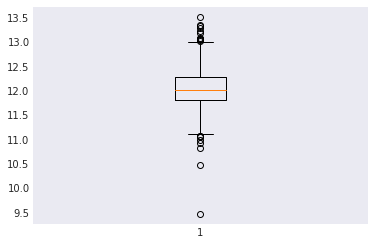

In [206]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df['target']))
plt.show()

`-` 로그 변환을 해서 나온 이상치들을 제거하자

In [207]:
def remove_outlier(df):
    Q1 = np.log(df).quantile(0.25)
    Q3 = np.log(df).quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = (np.log(df) >= Q1 - 1.5*IQR) & (np.log(df) <= Q3 + 1.5*IQR)
    return filter_

`-` df의 이상점을 제거한 df2를 만듦

In [337]:
df2 = df.copy()

In [209]:
df2['Overall_Qual'].unique()

array([10,  7,  5,  8,  6,  3,  4,  9,  2], dtype=int64)

`-` 위에서 제거한 이상점은 target의 이상점이다

`-` 그런데 위와 같이 이상점을 제거하면 target 전체를 기준으로 매우 큰 값 또는 작은 값만 제거된다

`-` 하지만 Overall Qual과 같은 변수로 target을 나눠서 보면 target 전체로 봤을 때의 이상점과 다르다

`-` 그렇기에 Overall Qual에 따른 target의 이상점을 제거하겠다

`-` 예컨대 Overall Qual이 3일 때 이상점으로 30만 달러의 집이 있다고 해도

`-` target 전체로 봤을 땐 이상점이 아니다

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거하자

In [338]:
l = []
for i in df2['Overall_Qual'].unique():
    l.extend(remove_outlier(df2.query('Overall_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가
             
l = list(set(l)) 
#& set(remove_outlier(df2[['target']]).query('target == True').index.tolist())

In [339]:
len(l)

1317

In [340]:
df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

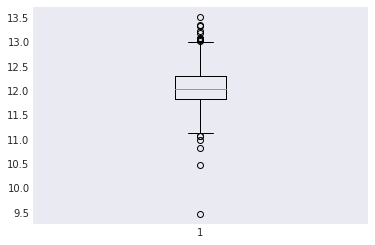

In [341]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df2['target']))
plt.show()

`-` 9.5부근에 있는 target은 제거해주자

In [342]:
df2[df2.target == df2.target.min()]

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
1176,2,832,2,2,780,2,678,832,1,1,1923,1970,1928,12789


In [343]:
df2 = df2.drop(df2[df2.target == df2.target.min()].index).reset_index().drop('index', axis = 1)

`-` 이상으로 이상점 제거를 마쳤다

<AxesSubplot:>

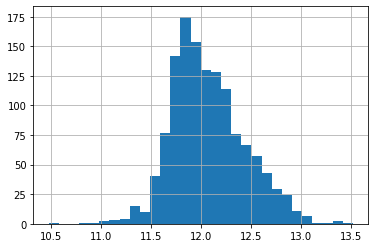

In [89]:
np.log(df2['target']).hist(bins = 30)

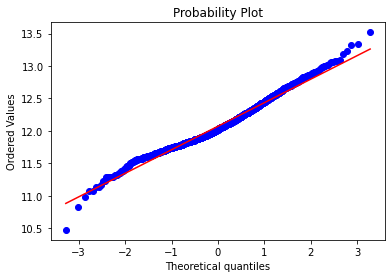

In [90]:
_ = stats.probplot(np.log(df2['target']), plot = plt)

In [220]:
test_stat, p_val = stats.shapiro(np.log(df2['target']))

In [221]:
p_val, np.log(df2['target']).skew() ## p값과 왜도

(1.6056494675509292e-11, 0.387183540371096)

`-` 이상으로 이상점 제거를 끝냈다

### 파생변수 생성

In [344]:
dt = df2.copy()

In [345]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [346]:
dt.drop('Garage_Yr_Blt', axis = 1, inplace = True)
test.drop('Garage_Yr_Blt', axis = 1, inplace = True)

`-` 차고 완공 연도 피쳐는 드랍

In [143]:
dict(zip(rf.feature_names_in_, rf.feature_importances_)) ## 연도 피쳐 포함

{'Overall_Qual': 0.3378385327427716,
 'Gr_Liv_Area': 0.1468019580807601,
 'Exter_Qual': 0.011952640943769247,
 'Garage_Cars': 0.010421908555938442,
 'Garage_Area': 0.12440988468275409,
 'Kitchen_Qual': 0.011950246437489973,
 'Total_Bsmt_SF': 0.07641459733627338,
 'First_Flr_SF': 0.09086582072221813,
 'Bsmt_Qual': 0.018361467288149972,
 'Full_Bath': 0.058033644454802774,
 'Year_Built': 0.06463448204518264,
 'Year_Remod_Add': 0.04831481670988958}

`-` 파생 변수를 만들자

`-` 이상점 제거 X 파트에서 만든 파생 변수를 조금 손봐보자 

`-` 퀄리티 관련 변수들을 그냥 더할 수 도 있다

`-` 하지만 퀄리티라고 해도 부엌의 퀄리티와 외관 재료의 퀄리티가 다를 수 있다(우선순위의 차이)

`-` 그러므로 위에서 랜덤포레스트를 통해 확인한 피쳐 중요도에 따라 다른 가중치를 두어 합치겠다

`-` 화장실의 개수도 화장실의 퀄리티이며 차고에 들어가는 차량의 개수도 차고의 퀄리티로 판단할 수 있다

`-` 이들을 다 고려하여 새로운 파생변수를 만들자

`-` 연도 피쳐는 주어진 피쳐가 설명하지 못하는 점들을 설명할 수 있을 가능성이 존재하니 살려두겠다(차고 완공 연도는 드랍)

In [347]:
def feature_eng2(data_):
    data = data_.copy()
    data['Year_Gap_Remod'] = data['Year_Remod_Add'] - data['Year_Built'] ## 완공을 하고 몇 년뒤에 리모델링을 했는지를 나타냄
    #data['Car_Area'] = data['Garage_Area'] / data['Garage_Cars'] ## car 하나당 차지하는 차고의 면적 ## 쓸모없어서 하지 않음 ## Garage_Area로 대체 가능
    data['Total_SF'] = data[['Gr_Liv_Area', 'Garage_Area', 'Total_Bsmt_SF']].sum(axis = 1) ## 전체 집의 면적
    data['The_Rest_Qual'] = data['Exter_Qual']*0.1 + data['Garage_Cars']*0.1 + data['Kitchen_Qual']*0.2 + data['Bsmt_Qual']*0.2 + data['Full_Bath']*0.3
    #data['The_Rest_Qual'] = (data['Exter_Qual'] + data['Garage_Cars'] + data['Kitchen_Qual'] + data['Bsmt_Qual'] + data['Full_Bath']) / 5
    #data['The_Rest_Qual'] = (data['Exter_Qual']*0.1 + data['Garage_Cars']*0.1 + data['Kitchen_Qual']*0.2 + data['Bsmt_Qual']*0.2 + data['Full_Bath']*0.3 + data['Overall_Qual']) / 2
    ## Overall_Qual은 다른 퀄리티 변수를 모두 포함하는 변수라 따로 취급했다
    
    data.drop(['Year_Remod_Add', 'Garage_Cars'] , axis = 1, inplace = True) ## 효용가치가 없는 변수 제거
    ## 다른 퀄리티 변수도 드랍할지 고민
    ## 1층은 냅뒀는데 집을 살 때 보통 1층을 먼저 볼것이니 1층이 중요하다고 생각함
    return data

In [348]:
dt2 = feature_eng2(dt)

### 파생변수 시각화

`-` 파생변수들을 시각화해보자

In [256]:
dt2['target'] = target ## 시각화를 위해 임시로 만듦

<AxesSubplot:>

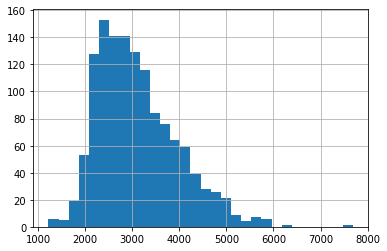

In [47]:
dt2.Total_SF.hist(bins = 30) ## 오른쪽으로 꼬리가 긴 분포

<AxesSubplot:xlabel='Total_SF', ylabel='target'>

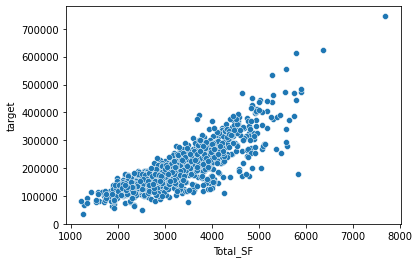

In [49]:
sns.scatterplot(x = 'Total_SF', y = 'target', data = dt2)

`-` 전체 면적이 거의 8000SF인 집이 있다

`-` 다른 데이터와 멀리 떨어져있어 이상점으로 생각할 수 있겠지만 

`-` 전체 면적과 집값이 보이는 흐름에서 멀리 떨어져있지는 않아 괜찮아 보인다

In [261]:
dt2['target'] = target

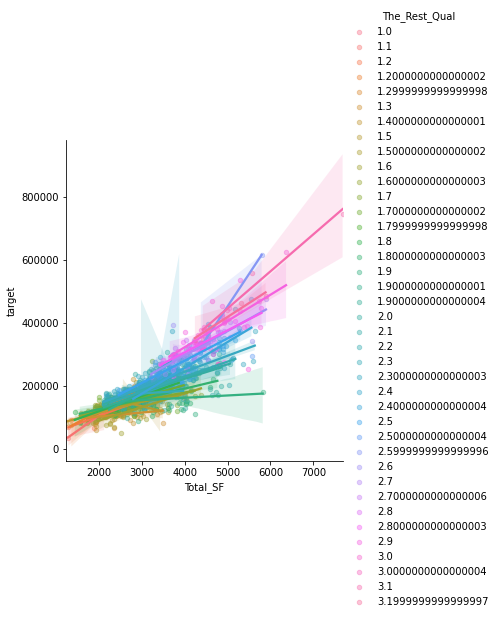

In [257]:
sns.lmplot(x = 'Total_SF', y = 'target', data = dt2, hue = 'The_Rest_Qual', scatter_kws = {'alpha':0.4, 's':20})

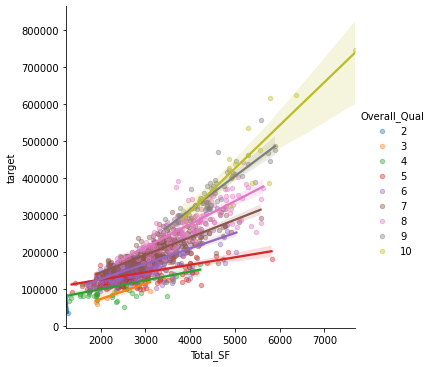

In [258]:
sns.lmplot(x = 'Total_SF', y = 'target', data = dt2, hue = 'Overall_Qual', scatter_kws = {'alpha':0.4, 's':20})

In [265]:
dt2.drop('target', axis = 1, inplace = True)

### 간단한 모델을 통한 피쳐 중요도 탐색

In [229]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, shuffle = True, test_size = 0.2, random_state = 22)

In [230]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [173]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')

In [231]:
log_target = np.log(target)

In [174]:
scores = cross_validate(rf, dt2, log_target, scoring = score, cv = 10)
rf.fit(x_train, log_y_train)
print('-----------------랜덤포레스트---------------------')
print('교차 검증별 NMAE: ', abs(scores['test_score']))
print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

-----------------랜덤포레스트---------------------
교차 검증별 NMAE:  [0.09426505 0.0952996  0.08771767 0.09303096 0.08775163 0.08824828
 0.10694089 0.08741147 0.0923854  0.09043555]
평균 교차 검증 NMAE:  0.0923486481930881
valid에 대한 검증 NMAE:  0.09182876232877228


In [148]:
rf.fit(dt2, log_target)

RandomForestRegressor(criterion='mae', random_state=22)

In [178]:
dict(zip(rf.feature_names_in_, rf.feature_importances_))

{'Overall_Qual': 0.14107841780994565,
 'Gr_Liv_Area': 0.057338942716802024,
 'Exter_Qual': 0.011230273145944528,
 'Garage_Area': 0.044720101050935886,
 'Kitchen_Qual': 0.013656097663298701,
 'Total_Bsmt_SF': 0.03485182723931557,
 'First_Flr_SF': 0.04525922362378785,
 'Bsmt_Qual': 0.008967493402191903,
 'Full_Bath': 0.004853986413651158,
 'Year_Built': 0.06024936713969412,
 'Year_Gap_Remod': 0.01530262981429434,
 'Total_SF': 0.4162230669125945,
 'The_Rest_Qual': 0.14626857306754384}

In [175]:
cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 3000, depth = 4, loss_function = 'MAE', verbose = 0)

In [176]:
cb.fit(dt2, log_target)

In [177]:
dict(zip(cb.feature_names_, cb.feature_importances_))

{'Overall_Qual': 16.865591556901975,
 'Gr_Liv_Area': 11.483090826813168,
 'Exter_Qual': 2.3423525531079474,
 'Garage_Area': 4.3616223584894245,
 'Kitchen_Qual': 1.9312962160141536,
 'Total_Bsmt_SF': 4.671094840360434,
 'First_Flr_SF': 6.345672589433746,
 'Bsmt_Qual': 2.5476814018701948,
 'Full_Bath': 1.4017680890522295,
 'Year_Built': 8.407197884360809,
 'Year_Gap_Remod': 2.611802859898884,
 'Total_SF': 22.728268151566546,
 'The_Rest_Qual': 14.30256067213049}

### 모델 앙상블

In [131]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

`-` 스케일링은 하지 않음

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [169]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 300, learning_rate = 0.03, max_depth = 4)
cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 3000, depth = 4, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 300, max_depth = 4, learning_rate = 0.03)

In [170]:
for model in [rf, gb, cb, xgb, lgb]:
    scores = cross_validate(model, dt2, log_target, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', abs(scores['test_score']))
    print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.09426505 0.0952996  0.08771767 0.09303096 0.08775163 0.08824828
 0.10694089 0.08741147 0.0923854  0.09043555]
평균 교차 검증 NMAE:  0.0923486481930881
valid에 대한 검증 NMAE:  0.09182876232877228
---------------------------------------------
교차 검증별 NMAE:  [0.0932479  0.09382758 0.08227268 0.08587716 0.09020278 0.08316386
 0.09733912 0.08400931 0.09329967 0.09819608]
평균 교차 검증 NMAE:  0.09014361330853202
valid에 대한 검증 NMAE:  0.08695017700516906
---------------------------------------------
교차 검증별 NMAE:  [0.08795301 0.09227423 0.07824809 0.08775099 0.09320167 0.08275337
 0.0957827  0.08546488 0.09464354 0.09439388]
평균 교차 검증 NMAE:  0.08924663669001828
valid에 대한 검증 NMAE:  0.08513308644657429
---------------------------------------------
교차 검증별 NMAE:  [0.08884182 0.09212601 0.08210941 0.08528204 0.09210695 0.08449326
 0.09821069 0.09240597 0.09084685 0.09375377]
평균 교차 검증 NMAE:  0.09001767855826212
valid에 대한 검증 NMAE:  0.08789482732040511
-----

In [292]:
test2 = feature_eng2(test)

In [248]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True)

`-` 랜덤포레스트

In [296]:
rf_valid = []
rf_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt2, log_target):
    x_train, y_train = dt2.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt2.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
    rf.fit(x_train, y_train)
    y_predict = np.exp(rf.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(rf.predict(test2)) ## test셋 예측

    rf_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    rf_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` cat 부스트

In [297]:
cb_valid = []
cb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt2, log_target):
    x_train, y_train = dt2.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt2.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 500, depth = 4, loss_function = 'MAE', verbose = 0)
    cb.fit(x_train, y_train)
    y_predict = np.exp(cb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(cb.predict(test2)) ## test셋 예측

    cb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 그래디언트 부스트

In [298]:
gb_valid = []
gb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt2, log_target):
    x_train, y_train = dt2.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt2.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    gb = GradientBoostingRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 4)
    gb.fit(x_train, y_train)
    y_predict = np.exp(gb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(gb.predict(test2)) ## test셋 예측

    gb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    gb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` xgb

In [299]:
xgb_valid = []
xgb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt2, log_target):
    x_train, y_train = dt2.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt2.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03) 
    xgb.fit(x_train, y_train)
    y_predict = np.exp(xgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(xgb.predict(test2)) ## test셋 예측

    xgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    xgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` lgbm

In [300]:
lgb_valid = []
lgb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt2, log_target):
    x_train, y_train = dt2.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt2.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    lgb = LGBMRegressor(random_state = 22, n_estimators = 500, max_depth = 4, learning_rate = 0.03)
    lgb.fit(x_train, y_train)
    y_predict = np.exp(lgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(lgb.predict(test2)) ## test셋 예측

    lgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    lgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 4개의 모형을 앙상블하자

In [302]:
np.mean(rf_valid), np.mean(gb_valid), np.mean(cb_valid), np.mean(xgb_valid), np.mean(lgb_valid)

(0.0932797809162971,
 0.09150833847465892,
 0.09164010389162143,
 0.09205270642067118,
 0.09072103094716263)

In [303]:
pred = (rf_predict + gb_predict + cb_predict + xgb_predict + lgb_predict) / 5 

In [304]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [305]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,335399.034649
1,2,125040.558297
2,3,173989.487515
3,4,250717.491861
4,5,134037.757004


In [306]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission10.csv', index = False)

`-` 점수는 $0.0935553928$이다

`-` 랜덤포레스트의 NMAE가 조금 높다

`-` 이를 제외한 모형을 앙상블해보자

In [315]:
pred = (gb_predict + cb_predict + xgb_predict + lgb_predict) / 4

In [316]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,338199.899338
1,2,123711.730245
2,3,172601.743726
3,4,248086.080387
4,5,135187.737567


In [309]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission11.csv', index = False)

`-` 점수는 $0.0934076125$이다

`-` 내가 위에서 모델 평가할 때 전체에 대해 교차검증을 하고

`-` train, valid로 나누어 평가를 했는데

`-` 처음부터 train, valid로 나누고 train에 대해서만 교차검증 하는 방식으로도 해보자

### 교호작용 추가 + Feature Selection

`-` 교호작용을 추가해보자

In [349]:
dt3 = dt2.copy()

In [350]:
test2 = feature_eng2(test)

In [352]:
dt3['Overall_Qual_Total_SF'] = dt3['Overall_Qual'] * dt3['Total_SF'] ## 전체적인 퀄리티와 집의 전체 면적을 곱함
dt3['Kitchen_Qual_First_Flr_SF'] = dt3['Kitchen_Qual'] * dt3['First_Flr_SF'] ## 부엌의 퀄리티와 1층 면적을 곱함(1층에 부엌이 있을 것)
dt3['Bath_Qual_First_Flr_SF'] = dt3['Full_Bath'] * dt3['First_Flr_SF'] ## 화장실 개수와 1층 면적을 곱함(1층에 화장실이 있을 것)
dt3['Bsmt_Qual_Total_Bsmt_SF'] = dt3['Bsmt_Qual'] * dt3['Total_Bsmt_SF'] ## 지하실 높이 수준과 지하실 면적을 곱함
#dt3['The_Rest_Qual_Total_SF'] = dt3['The_Rest_Qual'] * dt3['Total_SF']

In [353]:
test2['Overall_Qual_Total_SF'] = test2['Overall_Qual'] * test2['Total_SF'] ## 전체적인 퀄리티와 집의 전체 면적을 곱함
test2['Kitchen_Qual_First_Flr_SF'] = test2['Kitchen_Qual'] * test2['First_Flr_SF'] ## 부엌의 퀄리티와 1층 면적을 곱함(1층에 부엌이 있을 것)
test2['Bath_Qual_First_Flr_SF'] = test2['Full_Bath'] * test2['First_Flr_SF'] ## 화장실 개수와 1층 면적을 곱함(1층에 화장실이 있을 것)
test2['Bsmt_Qual_Total_Bsmt_SF'] = test2['Bsmt_Qual'] * test2['Total_Bsmt_SF'] ## 지하실 높이 수준과 지하실 면적을 곱함

In [354]:
test2.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Gap_Remod,Total_SF,The_Rest_Qual,Overall_Qual_Total_SF,Kitchen_Qual_First_Flr_SF,Bath_Qual_First_Flr_SF,Bsmt_Qual_Total_Bsmt_SF
0,9,1800,3,702,4,1800,1800,4,2,2007,0,4302,2.7,38718,7200,3600,7200
1,6,1082,2,240,2,1082,1082,2,1,1948,2,2404,1.4,14424,2164,1082,2164
2,6,1573,3,440,3,756,769,3,2,2000,0,2769,2.3,16614,2307,1538,2268
3,6,2443,3,744,3,1158,1158,3,2,2004,0,4345,2.4,26070,3474,2316,3474
4,5,1040,2,686,2,1040,1040,2,1,1968,0,2766,1.5,13830,2080,1040,2080


In [320]:
#dt3.drop(['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual', 'Full_Bath'], axis = 1, inplace = True)

In [332]:
#test2.drop(['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual', 'Full_Bath'], axis = 1, inplace = True)

`-` 드랍안한 것이 성능이 더 잘나옴

`-` 성능을 평가해보자

In [356]:
from sklearn.linear_model import Lasso, Ridge

In [357]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 350, learning_rate = 0.03, max_depth = 4)
cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 3000, depth = 4, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 350, max_depth = 3, learning_rate = 0.03)
ridge = Ridge(alpha = 0.4, random_state = 22)
lasso = Lasso(alpha = 0.008, random_state = 22)

In [366]:
x_train, x_valid, y_train, y_valid = train_test_split(dt3, target, shuffle = True, test_size = 0.2, random_state = 22)

In [367]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [362]:
log_target = np.log(target)

In [376]:
for model in [rf, gb, cb, xgb, lgb, ridge, lasso]:
    scores = cross_validate(model, dt3, log_target, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', abs(scores['test_score']))
    print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.10134241 0.10040301 0.09342677 0.090996   0.08993296 0.08286015
 0.105263   0.08686474 0.09782062 0.08647926]
평균 교차 검증 NMAE:  0.09353889158045361
valid에 대한 검증 NMAE:  0.09421556961367068
---------------------------------------------
교차 검증별 NMAE:  [0.0945999  0.09947476 0.08592917 0.08645308 0.08893089 0.07894581
 0.10403897 0.08896942 0.09249837 0.08562495]
평균 교차 검증 NMAE:  0.09054653233171701
valid에 대한 검증 NMAE:  0.08798846938568923
---------------------------------------------
교차 검증별 NMAE:  [0.09054723 0.09021781 0.08203305 0.08747055 0.09067075 0.08048582
 0.10230043 0.08706119 0.09089355 0.08638353]
평균 교차 검증 NMAE:  0.08880639062960194
valid에 대한 검증 NMAE:  0.08157018643446305
---------------------------------------------
교차 검증별 NMAE:  [0.09577003 0.09879315 0.08411884 0.08722169 0.08867808 0.07953855
 0.10860954 0.08940723 0.09062802 0.08383762]
평균 교차 검증 NMAE:  0.09066027495964635
valid에 대한 검증 NMAE:  0.08644301699576572
----

`-` 모델 앙상블

In [377]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True)

`-` 랜덤포레스트

In [384]:
rf_valid = []
rf_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
    rf.fit(x_train, y_train)
    y_predict = np.exp(rf.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(rf.predict(test2)) ## test셋 예측

    rf_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    rf_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` cat 부스트

In [385]:
cb_valid = []
cb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 3000, depth = 4, loss_function = 'MAE', verbose = 0)
    cb.fit(x_train, y_train)
    y_predict = np.exp(cb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(cb.predict(test2)) ## test셋 예측

    cb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 그래디언트 부스트

In [386]:
gb_valid = []
gb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    gb = GradientBoostingRegressor(random_state = 22, n_estimators = 350, learning_rate = 0.03, max_depth = 4)
    gb.fit(x_train, y_train)
    y_predict = np.exp(gb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(gb.predict(test2)) ## test셋 예측

    gb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    gb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` xgb

In [387]:
xgb_valid = []
xgb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03) 
    xgb.fit(x_train, y_train)
    y_predict = np.exp(xgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(xgb.predict(test2)) ## test셋 예측

    xgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    xgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` lgbm

In [388]:
lgb_valid = []
lgb_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    lgb = LGBMRegressor(random_state = 22, n_estimators = 350, max_depth = 3, learning_rate = 0.03)
    lgb.fit(x_train, y_train)
    y_predict = np.exp(lgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(lgb.predict(test2)) ## test셋 예측

    lgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    lgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` ridge

In [389]:
ridge_valid = []
ridge_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    ridge = Ridge(alpha = 0.4, random_state = 22)
    ridge.fit(x_train, y_train)
    y_predict = np.exp(ridge.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(ridge.predict(test2)) ## test셋 예측

    ridge_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    ridge_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` lasso

In [390]:
lasso_valid = []
lasso_predict = np.zeros(test2.shape[0])

for train_idx, valid_idx in kfold.split(dt3, log_target):
    x_train, y_train = dt3.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt3.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    lasso = Lasso(alpha = 0.008, random_state = 22)
    lasso.fit(x_train, y_train)
    y_predict = np.exp(lasso.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(lasso.predict(test2)) ## test셋 예측

    lasso_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    lasso_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 성능이 좋은 모형을 앙상블하자

In [391]:
np.mean(rf_valid), np.mean(gb_valid), np.mean(cb_valid), np.mean(xgb_valid), np.mean(lgb_valid), np.mean(ridge_valid), np.mean(lasso_valid)

(0.0942707986058594,
 0.09251502710113897,
 0.08906182700088569,
 0.09239366663817983,
 0.09242420208015215,
 0.09230907679723946,
 0.09266565396370621)

In [425]:
pred = (gb_predict + cb_predict + xgb_predict + lgb_predict + ridge_predict) / 5

In [367]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [427]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,336046.709249
1,2,128230.394997
2,3,172234.214137
3,4,249201.818059
4,5,134137.036193


In [369]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission20.csv', index = False)

In [428]:
# pred = (gb_predict + cb_predict + xgb_predict + lgb_predict) / 4
# 점수는 0.0929077786
# 선형모델은 성능이 좋지 않았음(스케일링도 안했고 피쳐수도 너무 많다)

`-` 트리 모형은 스케일링에 큰 영향을 받지 않는다

`-` 스케일링을 한다면 test 데이터에 대해 오차가 생길 수 밖에 없기에 굳이 안해도 되면 안할 것임

`-` 위에서는 10개의 폴드로 나누고 각각의 폴드로 test를 예측했는데

`-` 굳이 그러지말고 모델의 성능은 확인했으니 전체 train을 모델에 학습시키고 test를 예측했다

`-` 점수는 $0.0925983911$이다

```python
## 아래와 같이 코딩함
gb.fit(dt3, log_target)
xgb.fit(dt3, log_target)
lgb.fit(dt3, log_target)
cb.fit(dt3, log_target)

gb_pred = np.exp(gb.predict(test2))
lgb_pred = np.exp(lgb.predict(test2))
xgb_pred = np.exp(xgb.predict(test2))
cb_pred = np.exp(cb.predict(test2))

## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = (gb_pred + xgb_pred + lgb_pred + cb_pred) / 4
```

## 전체 집값과 Overall_Qual에 따른 집값을 기준으로 이상점 제거

`-` 모델의 하이퍼파라미터를 최적화시키지 않은 기준으로 보면 성능이 좋지 않았음

In [311]:
df2 = df.copy()

In [312]:
l = []
for i in df2['Overall_Qual'].unique():
    l.extend(remove_outlier(df2.query('Overall_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가
             
l = list(set(l) & set(remove_outlier(df2[['target']]).query('target == True').index.tolist()))

In [313]:
len(l)

1299

In [314]:
df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

`-` 이상으로 이상점 제거를 마쳤다

### 파생변수 생성

In [315]:
dt = df2.copy()

In [316]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [317]:
def feature_eng3(data_):
    data = data_.copy()
    data['Year_Gap_Remod'] = data['Year_Remod_Add'] - data['Year_Built'] ## 완공을 하고 몇 년뒤에 리모델링을 했는지를 나타냄
    #data['Car_Area'] = data['Garage_Area'] / data['Garage_Cars'] ## car 하나당 차지하는 차고의 면적 ## 쓸모없어서 하지 않음 ## Garage_Area로 대체 가능
    data['Total_SF'] = data[['Gr_Liv_Area', 'Garage_Area', 'Total_Bsmt_SF']].sum(axis = 1) ## 전체 집의 면적
    data['The_Rest_Qual'] = data['Exter_Qual']*0.1 + data['Garage_Cars']*0.1 + data['Kitchen_Qual']*0.2 + data['Bsmt_Qual']*0.2 + data['Full_Bath']*0.3
    #data['The_Rest_Qual'] = (data['Exter_Qual'] + data['Garage_Cars'] + data['Kitchen_Qual'] + data['Bsmt_Qual'] + data['Full_Bath']) / 5
    #data['The_Rest_Qual'] = (data['Exter_Qual']*0.1 + data['Garage_Cars']*0.1 + data['Kitchen_Qual']*0.2 + data['Bsmt_Qual']*0.2 + data['Full_Bath']*0.3 + data['Overall_Qual']) / 2
    ## Overall_Qual은 다른 퀄리티 변수를 모두 포함하는 변수라 따로 취급했다
    
    data.drop(['Year_Remod_Add', 'Garage_Cars', 'Garage_Yr_Blt'] , axis = 1, inplace = True) ## 효용가치가 없는 변수 제거
    ## 다른 퀄리티 변수도 드랍할지 고민
    ## 1층은 냅뒀는데 집을 살 때 보통 1층을 먼저 볼것이니 1층이 중요하다고 생각함
    return data

In [318]:
dt2 = feature_eng3(dt)

### 모델 앙상블

In [131]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

In [319]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, shuffle = True, test_size = 0.2, random_state = 22)

In [320]:
log_y_train = np.log(y_train)

In [321]:
log_target = np.log(target)

`-` 스케일링은 하지 않음

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [324]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 350, learning_rate = 0.03, max_depth = 4)
cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 1000, depth = 4, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 350, max_depth = 3, learning_rate = 0.03)

In [325]:
for model in [rf, gb, cb, xgb, lgb]:
    scores = cross_validate(model, dt2, log_target, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', abs(scores['test_score']))
    print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.08895869 0.0914522  0.08677014 0.09123053 0.0891177  0.08760941
 0.09715463 0.08516482 0.0932697  0.08679781]
평균 교차 검증 NMAE:  0.08975256140220303
valid에 대한 검증 NMAE:  0.08810418141089467
---------------------------------------------
교차 검증별 NMAE:  [0.08726128 0.09116885 0.080729   0.09069824 0.09045394 0.08012546
 0.0896421  0.08324834 0.09237142 0.08569798]
평균 교차 검증 NMAE:  0.0871396600590819
valid에 대한 검증 NMAE:  0.08402900953030686
---------------------------------------------
교차 검증별 NMAE:  [0.08107538 0.09046633 0.07543391 0.08588825 0.09295194 0.08103876
 0.08621714 0.08502467 0.09261    0.08554006]
평균 교차 검증 NMAE:  0.08562464371206577
valid에 대한 검증 NMAE:  0.08088816408151467
---------------------------------------------
교차 검증별 NMAE:  [0.08306371 0.09044917 0.08073993 0.08837718 0.09178245 0.08368917
 0.09027859 0.08916774 0.0909205  0.08469581]
평균 교차 검증 NMAE:  0.08731642577647392
valid에 대한 검증 NMAE:  0.08761443236809065
-----

In [327]:
test2 = feature_eng3(test)

In [329]:
rf.fit(dt2, log_target)
cb.fit(dt2, log_target)
gb.fit(dt2, log_target)
lgb.fit(dt2, log_target)
xgb.fit(dt2, log_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=22,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [333]:
pred = (np.exp(rf.predict(test2)) + np.exp(cb.predict(test2)) + np.exp(gb.predict(test2))+ np.exp(lgb.predict(test2))+ np.exp(xgb.predict(test2))) / 5

In [334]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [335]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,334786.425670
1,2,128105.519950
2,3,173958.213936
3,4,250719.737624
4,5,133995.721519


In [336]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission19.csv', index = False)

`-` 점수는 약 $0.973$